#  Named Entity Recognition with RNNs
This task is known as named entity recognition (NER). We’ll be using a modified version of the well-known Conference on Computational Natural Language Learning 2003 (CoNLL 2003) dataset for NER.It’s a more closely curated version than the original CoNLL, which contains errors in the dataset induced by incorrectly understanding the context of a word. For example, in the phrase “Chicago won ...” Chicago was identified as a location, whereas it’s actually an organization.



In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
# !pip install adjustText
%matplotlib inline
import zipfile
import re
import pandas as pd
import random
import numpy as np 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from adjustText import adjust_text

In [18]:
import os
import requests


def download_data(urls, data_dir):
    """Download specified files if not present."""
    
    os.makedirs(data_dir, exist_ok=True)
    
    for file_name in urls:
        file_path = os.path.join(data_dir, file_name)
        
        if not os.path.exists(file_path):
            print(f'Downloading {file_name}...')
            response = requests.get(urls[file_name])
            with open(file_path, 'wb') as f:
                f.write(response.content)
            print(f'{file_name} downloaded successfully.')
        else:
            print(f"{file_name} already exists.")

# URLs of the files to download
urls = {
    'conllpp_dev.txt': 'https://raw.githubusercontent.com/ZihanWangKi/CrossWeigh/master/data/conllpp_dev.txt',
    'conllpp_test.txt': 'https://raw.githubusercontent.com/ZihanWangKi/CrossWeigh/master/data/conllpp_test.txt',
    'conllpp_train.txt': 'https://raw.githubusercontent.com/ZihanWangKi/CrossWeigh/master/data/conllpp_train.txt'
}

download_data(urls, 'data')

conllpp_dev.txt already exists.
conllpp_test.txt already exists.
conllpp_train.txt already exists.


In [19]:
def read_data(filename):
    '''
    Read data from a file with given file name
    Returns a list of sentences (each sentence a string) 
    and list of ner labels for each string
    '''

    print("Reading data ...")
    # Manager lists - Holds sentences (list of tokens), ner_labels (for each token an NER label)
    sentences, ner_labels = [], [] 
    
    # Open the file
    with open(filename,'r',encoding='latin-1') as f:        
        # Read each line
        is_sos = True # We record at each line if we are seeing the beginning of a sentence
        
        # Tokens and labels of a single sentence, flushed when encountered a new one
        sentence_tokens = []
        sentence_labels = []
        i = 0
        for row in f:
            # If we are seeing an empty line or -DOCSTART- that's a new line
            if len(row.strip()) == 0 or row.split(' ')[0] == '-DOCSTART-':
                is_sos = False
            # Otherwise keep capturing tokens and labels
            else:
                is_sos = True
                token, _, _, ner_label = row.split(' ')
                sentence_tokens.append(token)
                sentence_labels.append(ner_label.strip())
            
            # When we reach the end or reach the beginning of next
            # Add the data to the manager lists, flush the temporary one
            if not is_sos and len(sentence_tokens)>0:
                sentences.append(' '.join(sentence_tokens))
                ner_labels.append(sentence_labels)
                sentence_tokens, sentence_labels = [], []
    
    print('\tDone')
    return sentences, ner_labels

In [20]:
# Train data
train_sentences, train_labels = read_data('data/conllpp_train.txt') 
# Validation data
valid_sentences, valid_labels = read_data('data/conllpp_dev.txt') 
# Test data
test_sentences, test_labels = read_data('data/conllpp_test.txt') 

# Print some data
print('\nSample data\n')
for v_sent, v_labels in zip(valid_sentences[:5], valid_labels[:5]):
    print(f"Sentence: {v_sent}")
    print(f"Labels: {v_labels}")
    print('\n')


Reading data ...
	Done
Reading data ...
	Done
Reading data ...
	Done

Sample data

Sentence: CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTER INNINGS VICTORY .
Labels: ['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Sentence: LONDON 1996-08-30
Labels: ['B-LOC', 'O']


Sentence: West Indian all-rounder Phil Simmons took four for 38 on Friday as Leicestershire beat Somerset by an innings and 39 runs in two days to take over at the head of the county championship .
Labels: ['B-MISC', 'I-MISC', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Sentence: Their stay on top , though , may be short-lived as title rivals Essex , Derbyshire and Surrey all closed in on victory while Kent made up for lost time in their rain-affected match against Nottinghamshire .
Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'B-

In [21]:
from itertools import chain

# Print the value count for each label
print("Training data label counts")
print(pd.Series(chain(*train_labels)).value_counts())

Training data label counts
O         169578
B-LOC       7140
B-PER       6600
B-ORG       6321
I-PER       4528
I-ORG       3704
B-MISC      3438
I-LOC       1157
I-MISC      1155
Name: count, dtype: int64


In [22]:
pd.Series(train_sentences).str.split().str.len().describe(percentiles=[0.05, 0.95])

count    14041.000000
mean        14.501887
std         11.602756
min          1.000000
5%           2.000000
50%         10.000000
95%         37.000000
max        113.000000
dtype: float64

In [23]:
def get_label_id_map(train_labels):
    # Get the unique list of labels
    unique_train_labels = pd.Series(chain(*train_labels)).unique()
    # Create a class label -> class ID mapping
    labels_map = dict(zip(unique_train_labels, np.arange(unique_train_labels.shape[0])))
    print(f"labels_map: {labels_map}")
    return labels_map

In [53]:
labels_map = get_label_id_map(train_labels)

labels_map: {'B-ORG': 0, 'O': 1, 'B-MISC': 2, 'B-PER': 3, 'I-PER': 4, 'B-LOC': 5, 'I-ORG': 6, 'I-MISC': 7, 'I-LOC': 8}


In [54]:
def get_padded_int_labels(labels, labels_map, max_seq_length, return_mask=True):

    # Convert string labels to integers 
    int_labels = [[labels_map[x] for x in one_seq] for one_seq in labels]
    
    
    # Pad sequences
    if return_mask:
        # If we return mask, we first pad with a special value (-1) and 
        # use that to create the mask and later replace -1 with 'O'
        padded_labels = np.array(
            tf.keras.preprocessing.sequence.pad_sequences(
                int_labels, maxlen=max_seq_length, padding='post', truncating='post', value=-1
            )
        )
        
        # mask filter
        mask_filter = (padded_labels != -1)
        # replace -1 with 'O' s ID
        padded_labels[~mask_filter] = labels_map['O']        
        return padded_labels, mask_filter.astype('int')
    
    else:
        padded_labels = np.array(ner_pad_sequence_func(int_labels, value=labels_map['O']))
        return padded_labels

In [10]:
max_seq_length = 40

In [11]:
# Convert string labels to integers for all train/validation/test data
# Pad train/validation/test data
padded_train_labels, train_mask = get_padded_int_labels(train_labels, labels_map, max_seq_length, return_mask=True)

padded_valid_labels, valid_mask = get_padded_int_labels(valid_labels, labels_map, max_seq_length, return_mask=True)

padded_test_labels, test_mask  = get_padded_int_labels(test_labels, labels_map, max_seq_length, return_mask=True)

In [68]:
# Print some labels IDs
print(padded_train_labels[:2])
print(train_mask[:2])

[[0 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]
 [3 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]]
[[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]]


#  Defining the model
We’ll define the model here. Our model will have an embedding layer, followed by a simple RNN layer, and finally, a dense prediction layer. One thing to note in the work we have done so far is that we haven’t yet defined a Tokenizer object. Although the Tokenizer has been an important part of our NLP pipeline to convert each token (or word) into an ID, there’s a big downside to using an external tokenizer. After training the model, if we forget to save the tokenizer along with the model, our machine learning model becomes useless: to combat this, during inference, we would need to map each word to the exact ID it was mapped to during training.

This is a significant risk the tokenizer poses. We’ll seek an alternative where we’ll integrate the tokenization mechanism right into our model so that we don’t need to worry about it later. The figure depicts the overall architecture of the model:
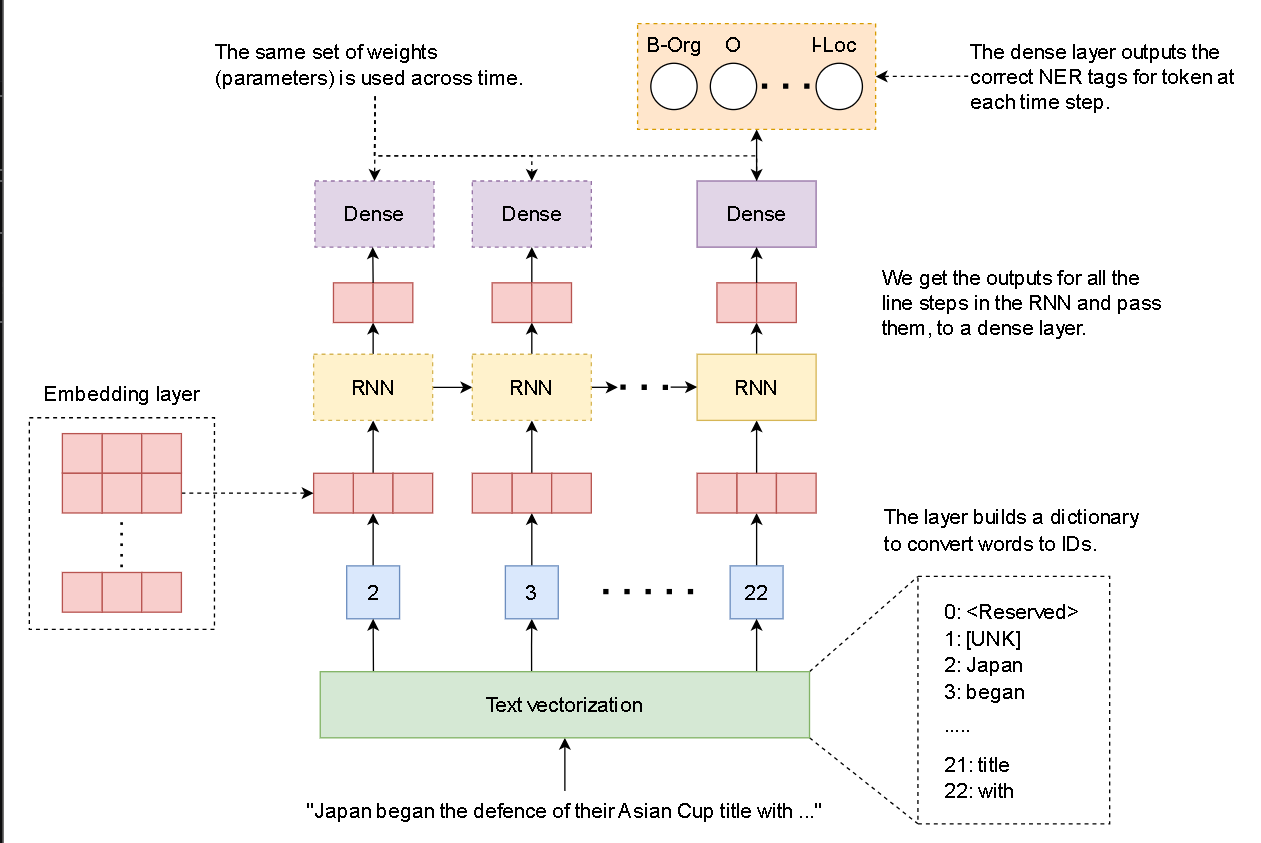